# Data synthesis using generative adversarial networks (GANs)

In this practical session we will build and train generative adversarial networks that are able to generate images.

This is a Google Colab notebook, which is mostly the same as a Jupyter notebook. This means that you can run the code in a cell by selecting the cell and pressing Shift+Enter. We will run everything in the cloud, so you don't need a fancy computer or an expensive GPU for this exercise. We are going to use GPUs that Google Cloud provides for free. To do this, go to Edit --> Notebook settings and select GPU as Hardware accelerator. Then, in the top right of this screen select 'CONNECT' --> 'Connect to hosted runtime'

We are going to import some of the packages that we will need in this exercise (by running the cell below)

The documentation for key packages can be found online: <br>
For numpy: https://docs.scipy.org/doc/numpy-dev/user/quickstart.html <br>
For matplotlib: http://matplotlib.org/api/pyplot_api.html <br>
For Keras: https://keras.io/ <br>
For random: https://docs.python.org/2/library/random.html <br>

In [ ]:
%tensorflow_version 1.x
import pickle
import gzip
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
from matplotlib import pylab
from IPython import display

import tensorflow as tf
import keras
keras.backend.set_image_data_format('channels_first')

import time
import random
from google.colab import files
from google.colab import widgets
random.seed(0)

# Check whether we're using a GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.logging.set_verbosity(tf.logging.ERROR)

Found GPU at: /device:GPU:0


## Small steps
Before moving on to generating images, we will start with a simple 1D problem. We will assume that there is a data set of real samples that are drawn from a normal distribution with a particular mean value (the black dotted line below). These samples are in the sample domain *x*. 

The generator network does not know anything about the distribution of the real samples in the sample domain *x*, but will try to come up with a transformation that maps random noise from a distribution *z* to samples that seem to come from the real sample distribution (the green line below). This is very similar to what we have looked at in the lecture.

<img src="https://cs.stanford.edu/people/karpathy/gan/gan.png">

For this, we will define two neural networks that play a game:
*   The discriminator will learn to distinguish real and fake samples in *z*
*   The generator will generate fake samples in *z* that the discriminator cannot discriminate

First, we determine the mean value of the normal distribution from which **real** samples will be drawn in the sample domain *x*. In addition, we define the dimensionality of the normal distribution *z* from which noise samples to the generator will be drawn, i.e. the latent space. This will be 1 for now.

In [ ]:
real_mean = 8
latent_dim = 1

Next, we define our discriminator and generator. These are both very simple networks.

**Question** How many layers does each of these networks have? 

Each network has three layers, two Dense layers and one activation layer (LeakyReLU).


**Question** Can you find out how many trainable parameters the networks have?

params_dense1 = ouput_size * (input_size + 1) = 32 * (1 + 1) = 64

params_reLU = output_size * (input_size + 1) = 0 * (32 + 1)

params_dense2 = ouput_size * (input_size + 1) = 1 * (32 + 1) = 33

total_params = params_dense1 + params_reLU + params_dense2 = 64 + 0 + 33 = 97

So both networks have 97 trainable parameters.


**Question** What are the activation functions of both networks? Why are they like this? 

The first network has two activation functions: the LeakyReLU and the sigmoid function. The second network has only the LeakyReLU activation function. 

LeakyReLU extends the range of the normal ReLU by not making the output of every negative x-value zero, but by using a slope such that the output can also take different negative values. This results in the mean of x closer to zero. Therefore, leakyReLU is more balanced compared to the normal ReLU, which makes it learn faster. 

When not using sigmoid, the output could take every value. Sigmoid ensures that the output of the discriminator lies between 0 and 1. 



In [ ]:
# For easier reading
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU

# The discriminator will directly classify the input value
def get_discriminator_1D():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(32, input_dim=1))
  discriminator.add(LeakyReLU())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

# The generator will transform a single input value
def get_generator_1D():
  generator = keras.models.Sequential()
  generator.add(Dense(32, input_dim=1))
  generator.add(LeakyReLU())
  generator.add(Dense(1))
  return generator

# showing a summary of the networks
model = get_discriminator_1D()
model.summary()

modelg = get_generator_1D()
modelg.summary()

Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 32)                64        
_________________________________________________________________
leaky_re_lu_269 (LeakyReLU)  (None, 32)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 32)                64        
_________________________________________________________________
leaky_re_lu_270 (LeakyReLU)  (None, 32)                0         
________________________________

Now, we will define the training functions for both networks. Consider what is actually happening in a GAN and how the inputs and outputs are connected. There are three variables when training this GAN

*   **z**: the noise that will be input to the generator
*   **G_z**: the output of the generator, i.e. the samples that should approximate the real samples
*   **D_G_z**: the discriminator's decision based on the fake sample

The overall objective function of our system is as follows

$V^{(D)}(D,G)=\underset{x\sim p_{data}}{\mathbb{E}} [\log{D(x)}]+\underset{z\sim p_z}{\mathbb{E}} [\log{(1-D(G(z)))}]$

The generator $G$ is trying to minimize this loss, and the discriminator $D$ tries to maximize this. In other words, the discriminator wants to minimize the binary cross-entropy s.t. it predicts 1 for real samples and 0 for fake samples. At the same time, the generator tries to get the discriminator to predict 1 for fake samples.




In [ ]:
# Get networks
discriminator = get_discriminator_1D()
generator = get_generator_1D()

# Configure both models for training
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

# To configure the full model, we will set the 'trainable' parameter of the discriminator to False, as we don't want to optimize the discriminator when optimizing the generator
discriminator.trainable = False

# The input variable (noise) for the generator
z = keras.layers.Input(shape=(latent_dim,))

# What comes out of the generator
G_z = generator(z)

# What comes out of the discriminator when classifying the 'fake' samples
D_G_z = discriminator(G_z)

# The full GAN model
gan = keras.models.Model(inputs=z, outputs=D_G_z)

# The loss function for the GAN: this gets lower if the fake samples are classified as real
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

The code below runs the training loop. This could take a while. The code will periodically show a plot of the current situation.

**Question** Why do we set discriminator.trainable to either True or False?

After setting the discriminator.trainable to False, the generator is trained. During optimization of the generator, you don't want to optimize the discriminator.

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

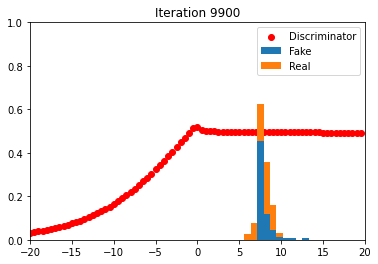

<IPython.core.display.Javascript object>

In [ ]:
# We will store the losses here
g_losses = []
d_losses = []

# Training loop
n_samples = 100
epochs = 10000

grid = widgets.Grid(1, 1)

for e in range(epochs):
  # Get a random set of normal distributed input noise
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
  #noise = np.random.uniform(0, 1, size=[n_samples, latent_dim])
  #noise = np.random.poisson(real_mean, size=[n_samples, latent_dim])
  
  # Also get a sample from the 'real' distribution
  real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
  #real = np.random.uniform(real_mean, 1, size=[n_samples, latent_dim])
  #real = np.random.poisson(real_mean, size=[n_samples, latent_dim])

  # Generate some fake samples using the generator
  fake = generator.predict(noise)
  
  # Concatenate the fake and real images
  X = np.concatenate([real, fake])

  # Labels for generated and real data
  Y_dis = np.zeros(2*n_samples)
  
  # Set labels for real samples to 1
  Y_dis[:n_samples] = 1

  # Train discriminator with this batch of samples
  discriminator.trainable = True
  d_loss = discriminator.train_on_batch(X, Y_dis)
  d_losses.append(d_loss)
  
  # Train generator with a new batch of generated samples
  # Freeze the discriminator part
  discriminator.trainable = False 
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
  # From the generator's perspective, the discriminator should predict
  # ones for all samples
  Y_gen = np.ones(n_samples)
  g_loss = gan.train_on_batch(noise, Y_gen)
  g_losses.append(g_loss)
  
  if e % 100 == 0:
    noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
    fake = generator.predict(noise)        
    real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
    pred = discriminator.predict(np.arange(-20, 20, 0.5).reshape((80, 1)))
    with grid.output_to(0, 0):
      grid.clear_cell()
      
      # plt.clf()
      pylab.hist((np.squeeze(fake), np.squeeze(real)), density=True, stacked=True)
      pylab.scatter(np.arange(-20, 20, 0.5), pred, c='r')     
      pylab.xlim(-20, 20)
      pylab.ylim(0, 1)
      pylab.title('Iteration {}'.format(e))
      pylab.legend(['Discriminator', 'Fake', 'Real'])
    time.sleep(0.5)


If all is well, the fake and real distributions should nicely overlap after training. The discriminator has essentially pushed the fake samples towards the real distribution and the generator is now able to transform the noise distribution into a distribution of 'real' samples!

**Question** Can you explain what happened to the red line during training? Why does it look like it does after training?

The red dotted line is the prediction of the discriminator. During training, the overlap between the points z mapped by the generator to some point on the sample distribution x, and the real data distribution, increases. The generator keeps getting feedback from the discriminator, thereby increasing the overlap each iteration. When convergence has reached, the curves overlap and the prediction of the prediction of the discriminator (red line) stays constant around 0.5. This means that the discriminator cannot distinguish between real and fake (synthesized) samples anymore.


**Question** Try training the GAN with different input noise distributions, e.g. uniform.

Uniform and poisson input noise distributions are used for training. All combinations from normal, uniform and poisson noise and real samples are examined. 


**Question** See if you can find a distribution for the real samples for which the generator fails to generate samples.

The generator fails to generate samples with a uniform or poisson noise distribution for uniform and poisson real samples. This can be seen in the not horizontal line at the complete domain of the real and fake samples, and by the only small amount of overlapping samples. With poisson distributed noise and uniform distributed real samples, the fake sample do not even move into the direction of the real ones, so the generator completely fails to generate samples. 
_______

During training, we have stored the loss values for the discriminator and the generator. We can now plot these. Remember that for the digit classification task, we were looking for a set of parameters leading to a low loss function. 

**Question** The loss curves that you get look different. Can you explain why they're not nicely dropping to zero? Can you explain the loss in the discriminator based on the objective function of the discriminator?

$G$ wants that his generated images look like the real ones while $D$ wants to observe a difference between the real and synthesized images. This means that improvements to $G$ lead to a higher loss in $D$ and vise versa. The goal of training the two models is to find an equilibirum between the two competing interests. It can be seen in the plot below that when the equilibrium is reached, the loss of both curves is equal to each other, approximately 0.7. Additionally, when the loss of $D$ decreases, the loss of $G$ increases, and vice versa. When the loss of $D$ would be zero, the loss of $G$ would be very high because it is not able to generate images that look like the real ones. On the other hand, when the loss of $G$ is zero, $D$ would have a very high loss because it is not able to ditinguish fake from real samples. 

The discriminator wants to maximize the objective function by assigning a high probability to real samples, $D(x)$, and a low probability to synthetic samples, $D(G(z))$. When $D(G(z)) = 1$, then $[\log{(1-D(G(z)))}] = - Inf $, which is very unfavorable because the discriminator wants to maximize its objective function. When $D(z) = 1$, then $[\log{(D(x))}] = 0$, which is the highest possible since all other options are negative. The loss thus increases when a lot of synthetic samples and few real samples are assigned with a high probability and decreases when a lot of real samples and few synthetic samples are assigned with a high probability. 

No handles with labels found to put in legend.


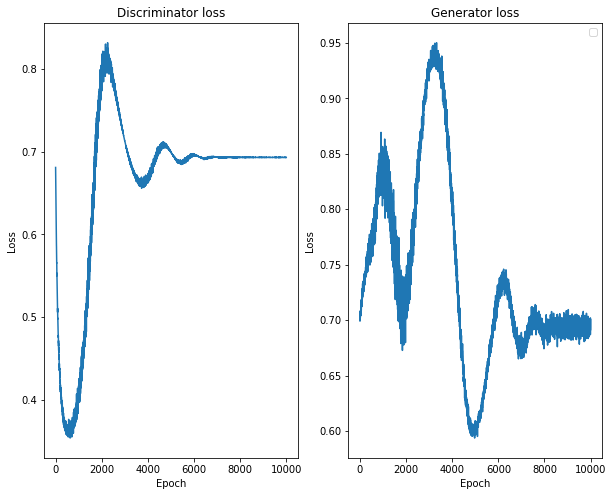

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Although it is definitely nice that we can train two networks together to learn the distribution of a real data distribution, generating samples from a normal distribution is in itself not really interesting. Luckily, we can use the same principles to generate images.

# MNIST synthesis
Like last week, we are again going to use MNIST data. Data preparation is the same as before.

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
train_set_images = np.expand_dims(x_train, axis=-1)
test_set_images = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
train_set_labels = to_categorical(y_train, num_classes=10)
test_set_labels = to_categorical(y_test, num_classes=10)


Plot some images.

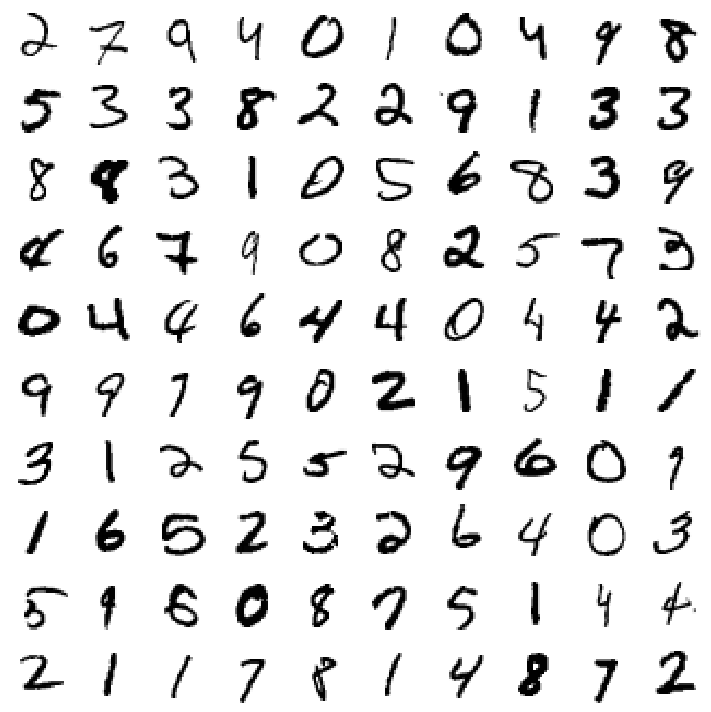

In [ ]:
def plotImages(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plotImages(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28))

In last week's exercise you have built a discriminative model that was able to classify an image into one of ten digit categories. In this exercise, we are going to do the inverse. Given a point in a latent space (which in our case will be a multi-dimensional Gaussian distribution), we are going to train the network to generate a realistic digit image for this point. The MNIST data set will be used as a set of real samples. 

<img src="https://skymind.ai/images/wiki/GANs.png">



## The discriminator
As you can see in the image above, we will need a generator and a discriminator network. Let's define these. Consider the network that you used
for digit classification in the previous exercise and see if you can spot some differences between that network and the network below.

**Question** Is this a convolutional neural network? Why (not)?

It is not a convolutional neural network, since it does not contain convolutional layers, but dense layers instead. It thus is a Dense model. Every Dense layer performs the same action as one single convolution, so multiple Dense layers are necessary instead of one convolutional layer. 


In [ ]:
def get_discriminator_MLP():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

You could argue that digits are a bit more complex than samples from a Gaussian distribution, so let's set the latent space dimensionality for noise sampling a bit higher than 1.

In [ ]:
latent_dim = 10


## The generator

The generator is different than the discriminator. It should go from a low-dimensional noise vector to an MNIST image.

In [ ]:
def get_generator_MLP():
  generator = keras.models.Sequential()
  generator.add(Dense(256, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  return generator

**Question** Consider the activation functions of the output layers of the generator and discriminator networks. How are they different?

The generator uses a tanh activation function, while the discriminator uses a sigmoid function for this. tanh is a hyperbolic tangent function which has a range between -1 and 1. Sigmoid on the other hand, has a range between 0 and 1, which makes it good in approximating functions that map into probability spaces, like the discriminator does. The advantage of tanh is that it makes it possible to map negative inputs to negative outputs.  


**Question** Also look at the activation functions of the other layers, can you find out what they do? Look at the Keras documentation.

The activation functions of the other layers is LeakyReLU. LeakyReLU extends the range of the normal ReLU by not making the output of every negative x-value zero, but by using a slope such that the output can also take different negative values. It thus allows a small gradient with negative slope coefficient alpha (the input coefficient which is set to 0.2 here) when the unit is not active. This results in the mean of x closer to zero. Therefore, leakyReLU is more balanced compared to the normal ReLU, which makes it learn faster.


## The model
Now  let's combine the generator and the discriminator. We train both using a binary crossentropy objective. This is very similar to what we did before.

In [ ]:
discriminator = get_discriminator_MLP()
generator = get_generator_MLP()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
G_z = generator(z)
D_G_z = discriminator(G_z)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
print

Some helper functions.

In [ ]:
def saveModels(epoch):
    generator.save('gan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('gan_discriminator_epoch_{}.h5'.format(epoch))
    
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch {}'.format(epoch))
    plt.show()

Run the code below to train the GAN model. Synthesized images should be shown periodically. 

In [ ]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 784).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):

    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # One-sided label smoothing
    y_dis[:batch_size] = 0.9

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

  # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    plotGeneratedImages(e)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e)



<Figure size 432x288 with 0 Axes>

**Question** Inspect the loss curves for this model and explain what happens.


The blue line in the plot below is the d_losses curve, the orange line is the g_losses curve. What is happening is that the two functions go to an equilibrium value. You can see that the g_losses curve comes down to aproximatly 1.25 and that the d_losses go up to 0.60. The model trains itself and it tries to get both the losses as close as is possible. 

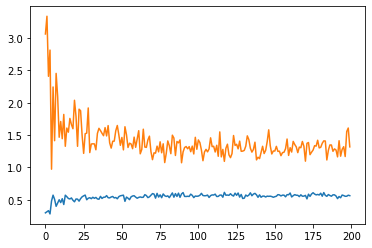

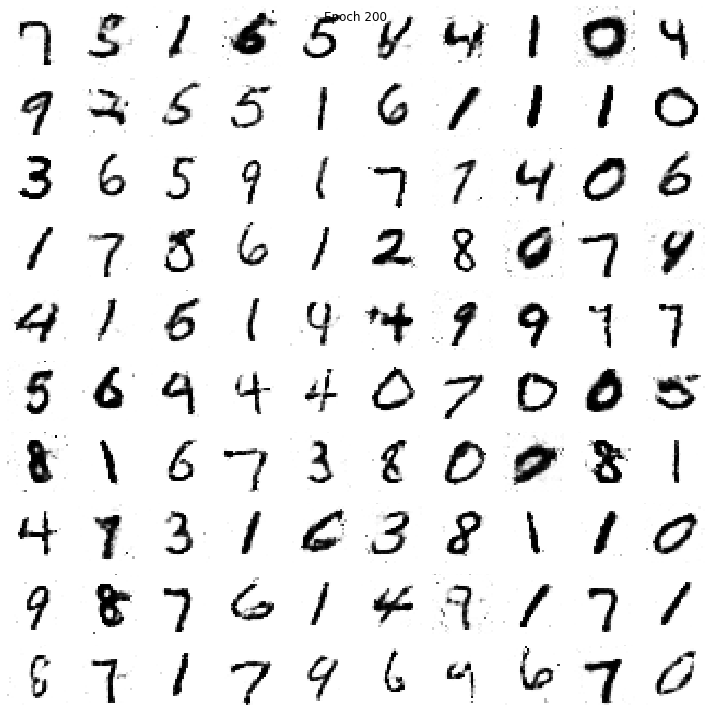

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(d_losses)
plt.plot(g_losses)
plt.show()
plotGeneratedImages(200)
display.display(plt.gcf()) #shows last epoch 


## A convolutional model
Thus far the discriminator and generator were both multilayer perceptrons. Now we're going to add in some convolutional layers to turn them into a deep convolutional GAN (<a href="http://arxiv.org/abs/1511.06434">DCGAN</a>)-like architecture. This means that we have to redefine the generator network and a discriminator network. 

The discriminator network is (almost) the same network that we used in last week's exercise.

In [ ]:
from keras.layers.convolutional import Conv2D, UpSampling2D

def get_discriminator_CNN():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
  return generator

Let's build our model like before.

In [ ]:
discriminator = get_discriminator_CNN()
generator = get_generator_CNN()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator(z)
D_G_z = discriminator(x)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

print(x.shape)

(?, 1, 28, 28)


Train the model using the code below. Inspect the samples that come out. 

**Question** What are some differences between these samples and the ones generated by the multilayer perceptron GAN? Can you explain these differences? 

The samples that are created in the MLP are generated while using a flattened vector version of the image, when this is done the spacial information is lost compared to the samples created by the CNN here the nodes that are used represent a area in the pictures so spacial information is used to help generate and classify the samples.

Another difference is that MLPs (Multilayer Perceptron) use one perceptron for each input (e.g. pixel in an image) and the amount of weights rapidly becomes unmanageable for large images. It includes too many parameters because it is fully connected. With a CNN the weights are smaller and shared — less wasteful, easier to train than MLP and more effective too. This also gives it less chance to overfit.

In [ ]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 1, 28, 28).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(100, 28, 28)          
    plotImages(generatedImages, title='Epoch {}'.format(e))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)    
    saveModels(e)

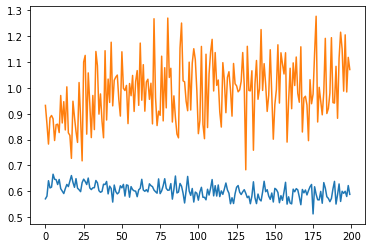

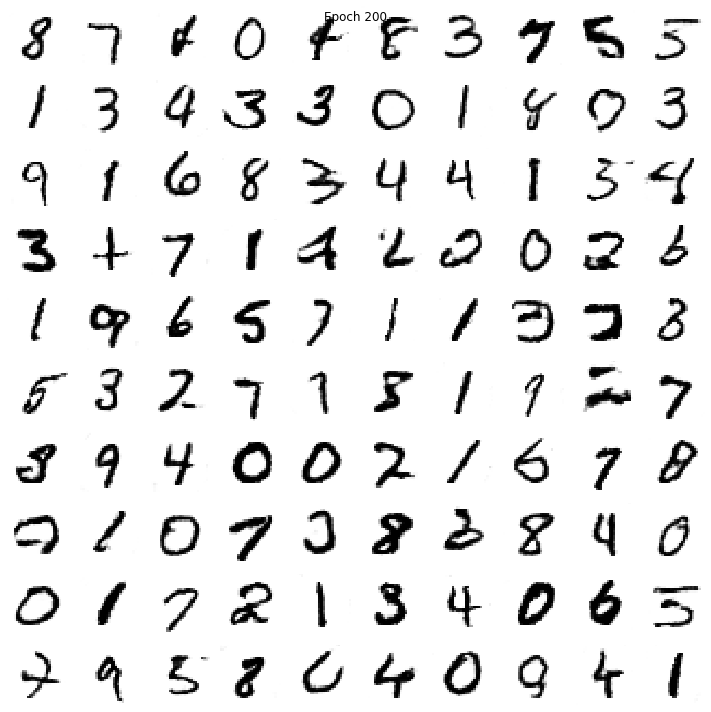

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(d_losses)
plt.plot(g_losses)
plt.show()
plotGeneratedImages(200)
display.display(plt.gcf()) #shows last epoch 

## Interpolation in the latent space
We're going to explore the latent space a bit more. We pick two points in the latent space and make a linear interpolation between these two. Then we generate images from each of the interpolated latent points. 

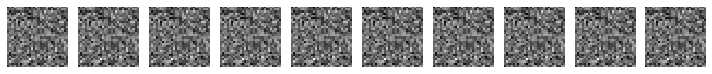

In [ ]:
noise_a = np.random.normal(0, 1, size=[1, latent_dim])
noise_b = np.random.normal(0, 1, size=[1, latent_dim])

noise = np.zeros((10, latent_dim), dtype='float32')
for ni in range(10):
  noise[ni, :] = float(ni)/10. * noise_a + (1 - float(ni)/10.) * noise_b
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(10, 28, 28)          
plotImages(generatedImages, dim=(1, 10), figsize=(10, 10))

**Question** Explain what you see in this plot.

The concept of latent space is very important for machine learning: learning the features of data and simplifying data representations for the purpose of finding patterns. The latent space is a representation of compressed data. Interpolating on latent space means collecting two points and making a line between those two points. The plot that is visible above shows a changing figure from the first point in latent space to the second point in latent space. The most left image is the first point in latent space, the most right image is the second point in latent space. The images in between show the transformation from the first point to the second point. As you can see, the left and right image look very alike. With this information you can tell that those points are close together in latent space. In latent space, points that are similar are closer together. 

**Question** What happens when you extrapolate out of the latent space distribution? Consider how the noise vectors are drawn.

Neural networks can be trained to map from one specific dataset to another, they usually do not learn a generalized transformation that can extrapolate accurately outside the space of training (Amodio, van Dijk, Montgomery, Wolf, Krishnaswamy, 2018). Probably, when you extrapolate out of the latent space distribution, the model will not be good. A lot of noise will occur because the features that your model is based on are not used to make your model anymore since you extrapolate out of latent space. Noise vectors will be large. 

_Reference_:
Amodio, M., van Dijk, D., Montgomery, R., Wolf, G., & Krishnaswamy, S. (2018). Out-of-Sample Extrapolation with Neuron Editing. arXiv preprint arXiv:1805.12198.

# Histopathology image synthesis

Now we're going to synthesize some actual images. We're going to use the PatchCamelyon data set ([more info here](https://github.com/basveeling/pcam)) which consists of small images that can be used for classification benchmarks. Today, we're not going to classify images, but we're going to synthesize them. You can download a data set of smaller (28 x 28 pixels) versions of these images from 
[this link](https://drive.google.com/file/d/11tkBWleY6PqFAGQHW0zYOwhvuz0kq-ai/view?usp=sharing). Upload the data set in the dialog below.

In [ ]:
uploaded = files.upload()

Saving valid_28.pkl.gz to valid_28.pkl (1).gz


Now load the data set.

In [ ]:
def loadPatchCamelyon(path):    
    f = gzip.open(path, 'rb')
    train_set = pickle.load(f, encoding='latin1')
    f.close()
    return train_set

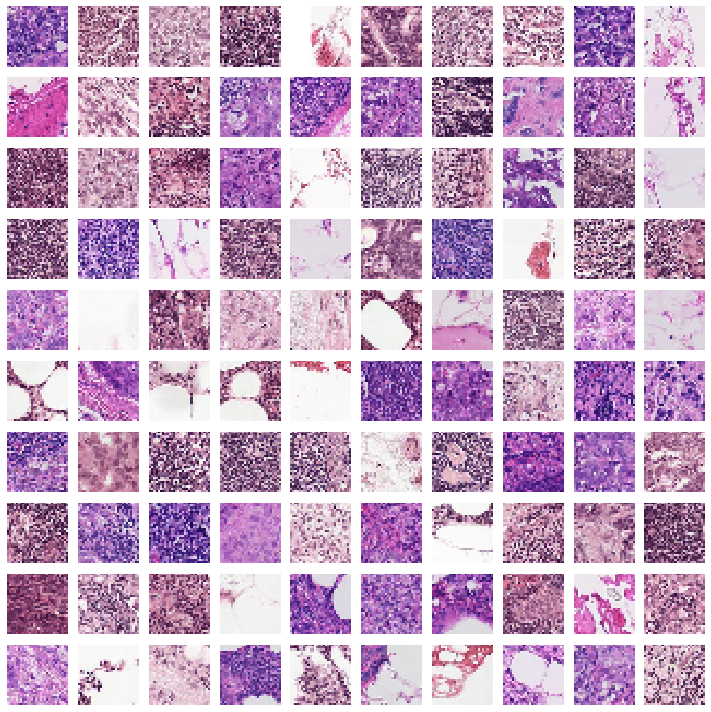

In [ ]:
train_set_images = loadPatchCamelyon(r'valid_28.pkl.gz')

def plotImagesPatchCamelyon(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
    
plotImagesPatchCamelyon(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28, 3)/255.0)

What do you immediately notice? Indeed, these images are in color! So the generator will have to generate three output channels instead of just one. 

In this second-to-last part of the practical you're going to repurpose the code that you have used so far to synthesize histopathology images like the ones above. You can play around a bit with this, see what happens when you interpolate between samples, etc. Remember that there is a final 'exercise' below.

**Good luck!**

For each color channel, we made a batch of the real samples and generated fake samples with the generator. Thereafter, these are concatenated and used for training of the discriminator. However, we kept getting this dimensions error: "Depth of input (3) is not a multiple of input depth of filter (28) for 'sequential_129/conv2d_273/convolution' (op: 'Conv2D') with input shapes: [?,3,56,56], [5,5,28,64]" or something like this. We tried using a different input shape of the discriminator to use all three channels at once. For this, we gave a list of Numpy arrays as input to discriminator_PC.train_on_batch, but this also raised an error. Lastly, we tried dividing the batches with get_batch. 

Concluding, we were not able to synthesize the histopathology images with DCGAN, so we could not look at the effect of interpolating between the samples, changing the parameters of for example the learning rate, kernel size and beta. However, we expect that interpolating in latent space lead to better results. This is explained above. 

In [ ]:
def get_batch(x_train, batch_size=128, change_colors=True):
    
    # Select random batch (WxHxC)
    idx = np.random.choice(x_train.shape[0])
    batch_raw = x_train[idx, :, :, 0].reshape((batch_size, 28, 28, 1))
    
    # Resize (this is optional but results in a training set of larger images)
    batch_resized = np.asarray([scipy.ndimage.zoom(image, (2.3, 2.3, 1), order=1) for image in batch_raw])
    
    # Extend to RGB
    batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis=3)
    
    # Convert the MNIST images to binary
    batch_binary = (batch_rgb > 0.5)
    
    # Create a new placeholder variable for our batch
    batch = np.zeros((batch_size, 64, 64, 3))
    
    for i in range(batch_size):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 64)
        y_c = np.random.randint(0, lena.size[1] - 64)
        image = lena.crop((x_c, y_c, x_c + 64, y_c + 64))
        # Conver the image to float between 0 and 1
        image = np.asarray(image) / 255.0

        if change_colors:
            # Change color distribution
            for j in range(3):
                image[:, :, j] = (image[:, :, j] + np.random.uniform(0, 1)) / 2.0

        # Invert the colors at the location of the number
        image[batch_binary[i]] = 1 - image[batch_binary[i]]
        
        batch[i] = image

    return batch

In [ ]:
## YOUR CODE GOES HERE
from keras.layers import BatchNormalization

# Add thirth dimension for RGB values
def get_discriminator_CNN_3():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(28, 28, 1), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
  return generator


# PatchCamelyon (PC) dataset
discriminator_PC = discriminator()
generator_PC = generator()

discriminator_PC.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator_PC.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator_PC.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator_PC(z)
D_G_z = discriminator_PC(x)
gan_PC = keras.models.Model(inputs=z, outputs=D_G_z)
gan_PC.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))


d_losses_PC = []
g_losses_PC = []

epochs = 50
batch_size = 128

X_train = (train_set_images.reshape(train_set_images.shape[0], train_set_images.shape[1], train_set_images.shape[2], 3).astype(np.float32) - 0.5)/0.5
X_train_r = (train_set_images[:,:,:,0].reshape(train_set_images.shape[0], 1, train_set_images.shape[1], train_set_images.shape[2]).astype(np.float32) - 0.5)/0.5
X_train_g = (train_set_images[:,:,:,1].reshape(train_set_images.shape[0], 1, train_set_images.shape[1], train_set_images.shape[2]).astype(np.float32) - 0.5)/0.5
X_train_b = (train_set_images[:,:,:,2].reshape(train_set_images.shape[0], 1, train_set_images.shape[1], train_set_images.shape[2]).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):

    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch_r = X_train_r[np.random.randint(0, X_train_r.shape[0], size=batch_size)]
    image_batch_g = X_train_g[np.random.randint(0, X_train_g.shape[0], size=batch_size)]
    image_batch_b = X_train_b[np.random.randint(0, X_train_b.shape[0], size=batch_size)]

    image_batch = get_batch(X_train, batch_size)
    
    # Generate some fake MNIST images using the generator
    generated_images = generator_PC.predict(noise) # output channel for red
    #generated_images_g = generator_PC.predict(noise) # output channel for green
    #generated_images_b = generator_PC.predict(noise) # output channel for blue
    
    # Concatenate the fake and real images
    X_r = np.concatenate([image_batch_r, generated_images])
    X_g = np.concatenate([image_batch_g, generated_images])
    X_b = np.concatenate([image_batch_b, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # One-sided label smoothing
    y_dis[:batch_size] = 0.9

    # Train discriminator with this batch of samples
    discriminator_PC.trainable = True
    d_loss_PC = discriminator_PC.train_on_batch([X_r, X_g, X_b], y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator_PC.trainable = False

    # Train the GAN to predict ones
    g_loss_PC = gan.train_on_batch(noise, y_gen)

  # Store loss of most recent batch from this epoch
  d_losses_PC.append(d_loss_PC)
  g_losses_PC.append(g_loss_PC)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    plotGeneratedImages(e)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e)






ValueError: ignored

# Conditional image synthesis

## The BigGAN model
The images we have synthesized so far are all quite small. Synthesis of larger images (e.g. 512 x 512 pixels) typically requires a lot of compute power and patience. Unfortunately, you don't have 100s of GPU at your disposal (I guess) to train a model like BigGAN, the state of the art in conditional image synthesis. A wild guess is that it would cost you around [USD60000](https://twitter.com/quasimondo/status/1065610256917692416) to train this model.

Luckily, the authors of BigGAN have put a version of their pretrained model online and you can use it to synthesize images. Go to [this Colaboratory file](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb) and answer the following questions.

**Question** What happens when you change the noise seed? Also try out different categories.

Answer:
 
With the noise seed you can generate the same random image again and again. When you change the noise seed, you get other (random) images. 
In total, there are 1000 different categories. When trying another category, the image/subject is changed. For example, category 933 shows cheeseburgers and category 966 shows red wine. 


**Question** What happens to your samples when you change the truncation value? More precisely, what happens to the diversity and the quality of your samples? Take a look at the [paper on arXiv](https://arxiv.org/abs/1809.11096) Sec. 3.1 to get an idea what this value does.

Answer:

Truncation is a simple sampling technique that allows fine-grained control of the tradeoff between sample variety and fidelity. When you increase the truncation value (max 1), it gives a higher diversity of the samples. However, the quality of the samples decreases. When you decrease the truncation value (min 0.02), it gives a lower diversity of the samples and a higher quality of the samples. 

**Question** Interpolate between image categories, inspect what these look like. 

Answer:

 
When we interpolate between image categories, we find out that other categories are used to go from domain A to domain B. For example, when we interpolate between a golden retriever and a shark, an intermediate step is another dog breed and another intermediate step is a tent-like object. 




## Conditional MNIST synthesis
For all MNIST samples we already have labels (0, 1, ..., n). Try to change the MNIST synthesis code such that you can ask the generator to generate specific labels. I.e., try to train a conditional GAN. You can look for some inspiration in [this paper](https://arxiv.org/pdf/1411.1784.pdf), in particular Sec. 4.1. Remember that you already got the MNIST labels when loading the data set.

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Target_Digit = 3
x_train_specific = x_train[y_train==Target_Digit]
y_train_specific = y_train[y_train==Target_Digit]


# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)
x_train_specific = (x_train_specific / 255.0).astype(np.float32)
y_train_specific = (y_train_specific / 255.0).astype(np.float32)

# convert the data to channel-last
train_set_images = np.expand_dims(x_train, axis=-1)
test_set_images = np.expand_dims(x_test, axis=-1)
train_set_images_specific = np.expand_dims(x_train_specific,axis=-1)


# convert the labels to one-hot encoded
train_set_labels = to_categorical(y_train, num_classes=10)
test_set_labels = to_categorical(y_test, num_classes=10)
train_set_labels = to_categorical(y_train_specific,num_classes = 1)


print(train_set_images.shape)


(60000, 28, 28, 1)


In [ ]:
latent_dim = 10

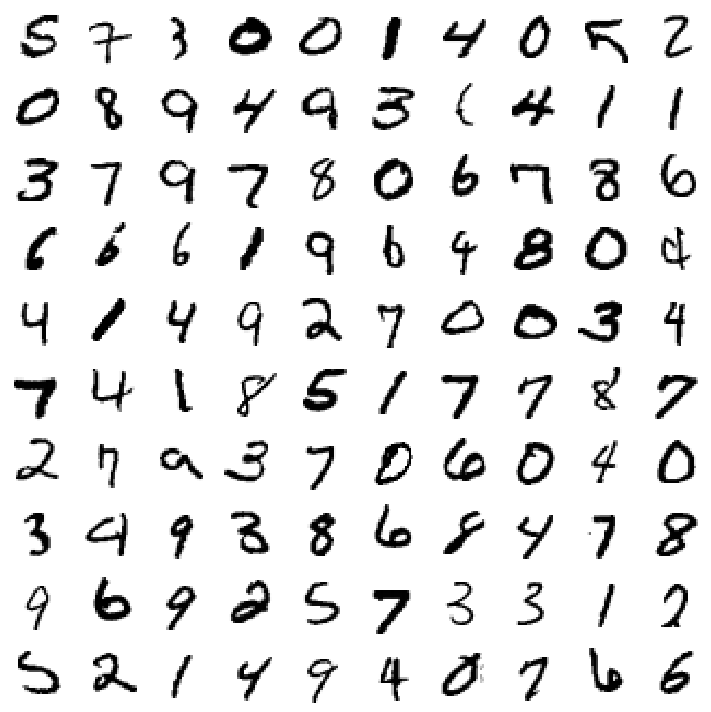

In [ ]:
def plotImages(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plotImages(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28))

Run the code below to train the GAN model. Synthesized images should be shown periodically. 

In [ ]:
d_losses = []
g_losses = []

epochs = 50
batch_size = 128
reshape_fac = train_set_images_specific.shape[0]
X_train = (train_set_images.reshape(reshape_fac, 784).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):

    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # One-sided label smoothing
    y_dis[:batch_size] = 0.9

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

  # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    plotGeneratedImages(e)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e)



<Figure size 432x288 with 0 Axes>

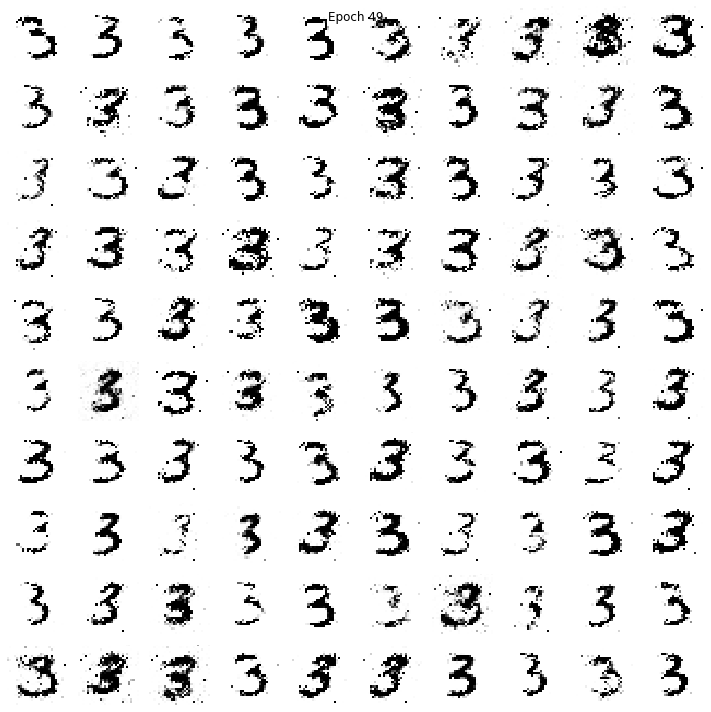

<Figure size 432x288 with 0 Axes>

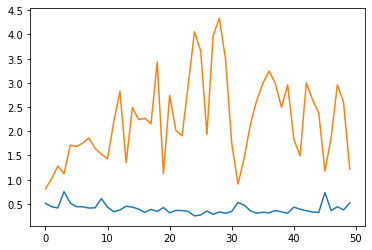

In [ ]:

plotGeneratedImages(e)
display.display(plt.gcf())

plt.plot(d_losses)
plt.plot(g_losses)
plt.show()


We tried to alter the generator function in such a way that a single lable could be entered and that it would be the only digit that will be generated. This did not want to work unfortunatly so to still get only one number that is being generated we filtered the training data and used only the data with the desired lable in the generator and discriminator so that it would only do one digit instead of all the digits

# Pretrained models

You can download some pre-trained generator models for the GAN training exercises from [this link](https://filesender.surf.nl/?s=download&token=475362bb-4098-4376-979b-b0d3ae9e3dd0), but of course it's much more interesting to train them yourself. Use 


```
generator = keras.models.load_model(filename)
```

to load the model.
